# Klasifikace obrázků CIFAR-10 pomocí vícevrstvého perceptronu

Úkolem cvičení je natrénovat vícevrstvý perceptron pro klasifikaci na datasetu CIFAR-10 s alespoň 50% úpěšností na validační sadě.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')  # import tests

import torch
import torchvision

import ans
from tests import test_multilayer_perceptron
from tests import randn_var

# Třída `ans.optim.Optimizer`

 Ve cvičení [neural-library](neural-library.ipynb) jsme navrhli vrstvy sítě jako objekty, které je možné libovolně skládat za sebou použitím třídy `Sequential`. Jednoduchý model zadefinujeme např. takto:

In [3]:
model = ans.modules.Sequential(
    ans.modules.Linear(4, 4),
    ans.modules.Sigmoid(),
    ans.modules.Linear(4, 3),
    ans.modules.Sigmoid(),
    ans.modules.Linear(3, 2)
)
model

Seznam parametrů získáme metodou `named_parameters()`.

In [4]:
model.named_parameters()

[('0.bias', Variable(shape=(4,), grad_fn=None)),
 ('0.weight', Variable(shape=(4, 4), grad_fn=None)),
 ('2.bias', Variable(shape=(3,), grad_fn=None)),
 ('2.weight', Variable(shape=(4, 3), grad_fn=None)),
 ('4.bias', Variable(shape=(2,), grad_fn=None)),
 ('4.weight', Variable(shape=(3, 2), grad_fn=None))]

Trénování sítě bude spočívat v aktualizaci atributů `p.data` pomocí `p.grad` každého parametru `p`.
``` python
for name, par in model.named_parameters():
    par.data -= 1e-3 * par.grad  # SGD update with learning rate of 0.001
```

Uvedený kód implementuje update parametru `par` stochastickou metodou největšího spádu (Stochastic Gradient Descent, SGD). Proměnná `par` ve `for` cyklu je odkazem na objekt typu `Variable`, který jako svůj atribut drží jedna z vrstev modelu a používá ho např. při dopředném průchodu. Jelikož vedle SGD existují i jiné metody optimalizace parametrů, je vhodné kód výše refaktorovat do objektů tak, aby výměna SGD nař. za [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) byla otázkou max. jednoho řádku kódu. Zavedeme proto speciální modul `ans.optim`, který bude obsahovat optimalizační algoritmy, a v něm zadefinujeme základní třídu `Optimizer`, jež bude sloužit jako (abstraktní) vzorové rozhraní optimalizace.

In [5]:
ans.optim.Optimizer??

Metoda `__init__` třídy `Optimizer` převezme seznam parametrů modelu. Ten získáme např. jako `model.parameters()`. Metoda `parameters` je implementována v základní tříde `ans.modules.Module` a funguje podobně jako `named_parameters` - pouze výsledek vrací bez automaticky vygenerovaných jmen.

Metoda `step` bude pro každý optimizér jiná a bude implementovat nějaké konkrétní pravidlo updatu parametrů. V případě SGD půjde o kód uvedený výše.

Metoda `zero_grad` u všech parametrů, které má optimizér zaregistrovány ve svém atributu `self.parameters`, vynuluje atribut `grad` jeho nastavením na `None`. Metodu `zero_grad` bude nutné volat vždy před spuštěním zpětné propagace, jinak dojde k akumulaci gradientů např. z minulé dávky.

# (Momentum) Stochastic Gradient Descent (SGD)

Základní metodou optimalizace je stochastická metoda největšího spádu (Stochastic Gradient Descent, SGD). Po vzoru knihovny PyTorch budeme implementovat verzi s "hybností", tzv. Momentum SGD.

**Jeden krok optimalizace**

$$
\begin{split}
    % v^{(t)} & := \alpha \cdot v^{(t-1)} - \gamma \cdot \nabla l\left( v^{(t-1)} \right) \\
    % v^{(t+1)} & := \alpha \cdot v^{(t)} - \gamma \cdot \overline{\theta}} \\
    % \theta^{(t+1)} & := \theta^{(t)} + v^{(t+1)}
    \widehat{\theta}_{t} & := \overline{\theta}_t + \lambda \cdot \theta_{t} \\
    v_{t} & := \alpha \cdot v_{t-1} - \gamma \cdot \widehat{\theta}_{t} \\
    \theta_{t+1} & := \theta_{t} + v_t
\end{split}
$$
- všechny proměnné jsou reálná čísla (skaláry)
- $\theta_{t}$ a $\theta_{t+1}$ značí původní, resp. nově vypočtenou hodnotu jednoho z parametrů modelu (např. jednoho z prvků váhové matice)
<!-- - $\theta_{t}$ značí novou hodnotu parametru po provedení updatu metodou SGD -->
- $\overline{\theta}_t = \partial l_t / \partial \theta_{t}$ je gradient celkového lossu $l_t$ v iteraci $t$ vůči parametru $\theta_{t}$ získaný zpětnou propagací
- $\widehat{\theta}_{t}$ je upravený gradient se zohledněním regularizace
- $v_{t-1}$ a $v_t$ značí "rychlosti" (velocity) z minulého, resp. aktuálního kroku
- $\alpha \in [0, 1]$ (hyperparametr) je reálné číslo mezi 0 a 1 (včetně) a značí tzv. hybnost (momentum)
- $\lambda$ (hyperparametr) je koeficient L2 regularizace, tzv. weight decay
- $\gamma$ (hyperparametr) značí krok učení, tzv. learning rate

Krok bude implementovat metoda `step` třídy `SGD`. Projde všechny registrované parametry (proměnné typu `ans.autograd.Variable`) a *pokud obsahují `grad`, který není `None`*, dojde k updatu jejich atributu `data` uvedeným pravidlem. Atributy, jejichž `grad` je `None`, se z updatu vynechají.

### TODO: implementujte třídu `SGD` v modulu `ans.optim`

In [6]:
test_multilayer_perceptron.TestSGD.eval()

test_init (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_init) ... ok
test_momentum (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_momentum) ... ok
test_sgd (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_sgd) ... ok
test_weight_decay (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_weight_decay) ... ok
test_weight_decay_momentum (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_weight_decay_momentum) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.027s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

# Načtení dat a příprava dat

Kód pro načítání a zpracování dat bude velmi podobný cvičení [Lineární klasifikace](linear-classification.ipynb).

In [7]:
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train

In [8]:
val_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
val_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

Rozdíl bude ve funkci `preprocess`, která nyní bude zařizovat i konverzi do správného datového typu. Trénování je pak možné přepnutím jediného řádku díky podpoře v PyTorchi spustit i na grafické kartě, viz hlavní cyklus. V důsledku je tak nutné do `preprocess` posílat i `targets`, protože při výpočtech musejí být všechny tensory na stejném zařízení. Tensoru `targets` se to týká při výpočtu křížové entropie. Funkce pak bude vracet dvojici `(outputs, targets)`.

In [9]:
def preprocess(
        inputs: torch.Tensor,
        targets: torch.Tensor,
        dtype: torch.dtype = torch.float32,
        device: torch.device = torch.device(type='cpu')
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Args:
        inputs: n-dimensional tensor with first dimension of size num_inputs
        targets: 1-dimensional tensor (vector) with first dimension of size num_inputs
        dtype: to which data type should the inputs (not targets) be converted
        device: to which device should both inputs and targets be transferred
    Returns:
        outputs: 2-dimensional tensor; shape (num_inputs, num_features), dtype `dtype`, device `device`
        targets: 1-dimensional tensor (vector); shape (num_inputs,1) device `device`
    """
    
    ########################################
    # TODO: implement
    
    import numpy as np
    
    inputs = inputs.clone().detach().to(dtype=dtype, device=device)
    targets = targets.clone().detach().to(device=device)    
    outputs = torch.div(inputs, 255.0)
    curr_shape = outputs.shape
    num_inputs = curr_shape[0]
    shape_dim2 = np.prod(curr_shape[1:])
    outputs = outputs.reshape([num_inputs, shape_dim2])
    
    # ENDTODO
    ########################################
    
    return outputs, targets

In [10]:
test_multilayer_perceptron.TestPreprocess.eval(preprocess_fn=preprocess)

test_device (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_device) ... ok
test_dtype (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_dtype) ... ok
test_values (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_values) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.117s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Funkce pro trénování

In [11]:
def accuracy(scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Args:
        scores: output linear scores (logits before softmax); shape (num_samples, num_classes)
        targets: vector of class indicies (integers); shape (num_samples,)
    Returns:
        acc: averare accuracy on the batch; tensor containing single number (scalar), e.g. "tensor(0.364)"
    """
    
    ########################################
    # TODO: implement
    
    predictions = torch.argmax(scores.data, dim=1)
    correct_predictions = (predictions == targets.data).float()
    acc = correct_predictions.mean()
    
    # ENDTODO
    ########################################
    
    return acc

In [12]:
test_multilayer_perceptron.TestAccuracy.eval(accuracy_fn=accuracy)

test_accuracy (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_accuracy) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

Ve funkcích `train_step` a `val_step` předejte do `preprocess` zařízení a datový typ modelu. Získáte je jako `model.device()`, resp. `model.dtype()`. Nezapomeňte také na `zero_grad()`.

In [13]:
def train_step(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    model: ans.modules.Module,
    criterion: ans.modules.Module,
    optimizer: ans.optim.Optimizer
) -> tuple[float, float]:
    ########################################
    # TODO: implement
    
    inputs, targets = preprocess(inputs, targets, device=model.device(), dtype=model.dtype())
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backprop()
    optimizer.step()
    acc = accuracy(outputs, targets)
    
    # ENDTODO
    ########################################
    
    return loss.data.item(), acc.item()

In [14]:
def val_step(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    model: ans.modules.Module,
    criterion: ans.modules.Module
) -> tuple[float, float]:
    ########################################
    # TODO: implement
    
    inputs, targets = preprocess(inputs, targets, device=model.device(), dtype=model.dtype())
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    acc = accuracy(outputs, targets)
    
    # ENDTODO
    ########################################
    
    return loss.data.item(), acc.item()

In [15]:
test_multilayer_perceptron.TestSteps.eval(train_step_fn=train_step, val_step_fn=val_step)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_train_step (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_train_step) ... ok
test_val_step (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_val_step) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.050s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [16]:
def validate(
    loader: ans.data.BatchLoader,
    model: ans.modules.Module,
    criterion: ans.modules.Module
) -> tuple[float, float]:
    total_loss = 0.
    total_acc = 0.
    for inputs, targets in loader:
        loss, acc = val_step(inputs, targets, model, criterion)
        total_loss += loss
        total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

# Hlavní cyklus

### TODO: Natrénujte MLP model dosahující alespoň 50% úspěšnosti na validační sadě.

In [17]:
%%time

# reproducibility
ans.utils.seed_everything(0)

# hyperparameters
num_epochs = 6
batch_size = 512
learning_rate = 0.00099
weight_decay = 0.00001
hidden_size = 1024


# data loaders
train_loader = ans.data.BatchLoader(
    torch.tensor(train_dataset.data),
    torch.tensor(train_dataset.targets),
    batch_size=batch_size,
    shuffle=True
)
val_loader = ans.data.BatchLoader(
    torch.tensor(val_dataset.data),
    torch.tensor(val_dataset.targets),
    batch_size=batch_size,
    shuffle=False
)

input_size = 3 * 32 * 32
output_size = 10

# init parameters
model = ans.modules.Sequential(
    ans.modules.Linear(input_size, hidden_size),
    ans.modules.BatchNorm1d(hidden_size),
    ans.modules.ReLU(),
    #ans.modules.Dropout(0.5),
    ans.modules.Linear(hidden_size, hidden_size),
    ans.modules.BatchNorm1d(hidden_size),
    ans.modules.ReLU(),
    #ans.modules.Dropout(0.5),
    ans.modules.Linear(hidden_size, output_size)
)

if torch.cuda.is_available():
    model.to(device='cuda')
else:
    model.to(device='cpu')
    num_epochs = 9
    
# loss function
criterion = ans.modules.SoftmaxCrossEntropy()

# optimizer
optimizer = ans.optim.Adam(
    model.parameters(), 
    learning_rate=learning_rate,
    weight_decay=weight_decay
)

# validate once before training
train_loss, train_acc = validate(train_loader, model, criterion)
val_loss, val_acc = validate(val_loader, model, criterion)

# record history for plotting
history = ans.utils.MetricsHistory()
history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

# optimize
for epoch in range(num_epochs):
    # train loop
    model.train()
    for inputs, targets in train_loader:
        loss, acc = train_step(inputs, targets, model, criterion, optimizer)
        train_loss = 0.99 * train_loss + 0.01 * loss
        train_acc = 0.99 * train_acc + 0.01 * acc
    
    # validation loop
    model.eval()
    val_loss, val_acc = validate(val_loader, model, criterion)
    
    history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

       train_loss  train_acc  val_loss   val_acc
epoch                                           
0        2.385803   0.099015  2.387125  0.096507
1        1.888092   0.306927  1.461728  0.477970
2        1.561995   0.434977  1.371298  0.515815
3        1.368255   0.509864  1.312752  0.527309
4        1.238433   0.558567  1.301393  0.533324
5        1.139787   0.592841  1.282555  0.542595
6        1.053851   0.624588  1.278856  0.550000
CPU times: total: 6min 28s
Wall time: 1min 10s


train_loss    1.053851
train_acc     0.624588
val_loss      1.278856
val_acc       0.550000
Name: 6, dtype: float64


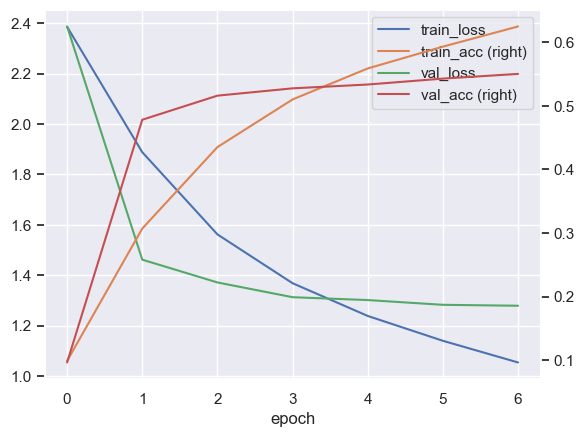

In [18]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

# Další vylepšení

Jako bonus můžete zkusit trochu vylepšit skóre sítě několika technikami. Implementujte postupně každou z nich, opakujte hlavní cyklus znovu a sledujte, zda a jak se mění výsledná přesnost na validační sadě (`val_acc`). Model by měl dosáhnout alespoň 55% přesnosti na validační množině. Výsledku lze navíc dosáhnout rychleji, tj. dříve a s menším počtem epoch.

## Preprocessing

Jako nejjednodušší vylepšení můžete zkusit vycentrovat data, která vstupují do sítě, tak, aby měla přibližně nulový průměr. Není nutné počítat průměr dávky či z celého datasetu. Od každé dávky znormalizované do rozsahu 0...1 jednoduše odečtěte 0.5.

### TODO: modifikujte funkci `preprocess` tak, aby prvky výstupu měly přibližně nulovou očekávanou hodnotu

In [19]:
test_multilayer_perceptron.TestPreprocess.eval(preprocess_fn=preprocess, centered=True)

test_device (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_device) ... ok
test_dtype (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_dtype) ... ok
test_values (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_values) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [20]:
# main loop

train_loss    1.053851
train_acc     0.624588
val_loss      1.278856
val_acc       0.550000
Name: 6, dtype: float64


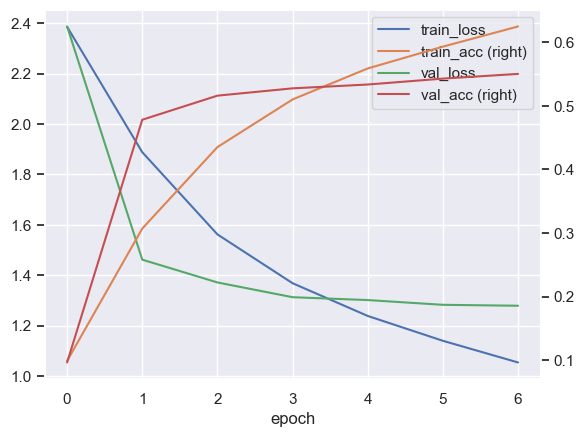

In [21]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Rectified Linear Unit (ReLU)

Sigmoid nelinearita nemá příliš vhodné vlastnosti pro zpětnou propagaci. Efektivnější se z tohoto pohledu se ukázala rektifikovaná lineární jednotka, tzv. ReLU.

**Dopředný průchod**

$$
z = \begin{cases}
    0 & \textrm{pokud} & x \le 0 \\
    x & \textrm{pokud} & x \gt 0 \\
\end{cases}
$$
- $x$ je reálné číslo (skalár)
- $z$ je reálně číslo (skalár)

**Zpětný průchod**

$$
\overline{x} = \begin{cases}
    0 & \textrm{pokud} & x \le 0 \\
    \overline{z} & \textrm{pokud} & x \gt 0 \\
\end{cases}
$$
- $\overline{z}$ je příchozí gradient na $z$

**Dávkové zpracování**

Operaci ReLU aplikujeme na všechny prvky vstupu nezávisle na sobě.

**Poznámka**

Jelikož operace ReLU není diferencovatelná, numerický gradient se pro malé hodnoty $x \approx 0$ kolem bodu zlomu v nule nechová jako subgradient a nevychází "správně". Pokud vám `gradcheck` v testu selže i přes podle vás správnou implementaci zpětného průchodu, zkuste ho opakovat. Pravděpodobnost selhávajícího testu je cca 27 %.

### TODO: implementujte funkci `ans.functional.ReLU` a vrstvu `ans.modules.ReLU`

In [22]:
ans.autograd.gradcheck(
    ans.functional.ReLU.apply,
    (
        randn_var(8, 4, std=10., name='input'),
    )
)

dinput FAIL: rel_err=8.196e-01, abs_err=5.334e-02

Analytic gradient: 
tensor([[ 2.1623,  1.0828,  0.0000, -0.0000],
        [-0.0678,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.6313,  0.8301,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1182],
        [ 0.0000, -0.0000, -0.1184, -0.3522],
        [-0.6949,  0.5582,  0.0000,  1.0653],
        [-0.3373, -0.2742, -0.0000,  2.1702],
        [ 0.5633,  0.0000,  0.8366, -1.8209]], dtype=torch.float64) 

Numeric gradient: 
tensor([[ 2.1623,  1.0828,  0.0000,  0.0000],
        [-0.0678,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.6313,  0.8301,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1182],
        [ 0.0000,  0.0000, -0.0651, -0.3522],
        [-0.6949,  0.5582,  0.0000,  1.0653],
        [-0.3373, -0.2742,  0.0000,  2.1702],
        [ 0.5633,  0.0000,  0.8366, -1.8209]], dtype=torch.float64) 

Relative error: 
tensor([[2.0538e-16, 2.0506e-15, 0.0000e+00, 0.0000e+00],
        [2.0458e-15, 0.0000e+00, 0.0000e+00, 0.0000

False

In [23]:
test_multilayer_perceptron.TestReLU.eval()

test_forward_function (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function) ... ok
test_forward_module (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_module) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.011s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [24]:
# main loop

train_loss    1.053851
train_acc     0.624588
val_loss      1.278856
val_acc       0.550000
Name: 6, dtype: float64


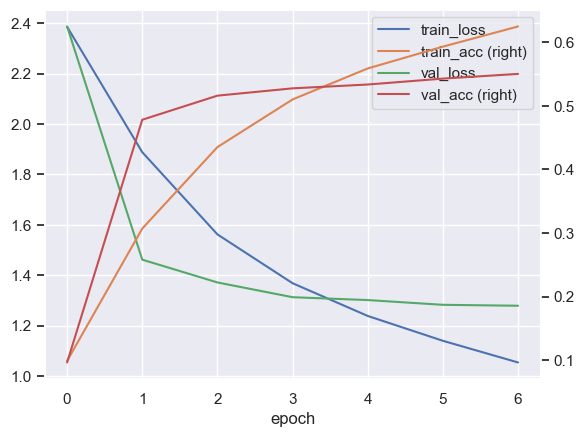

In [25]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Normalizace dávky (batch normalization)

Další vylepšení úspěšnosti je možné dosáhnout normalizací výstupů skrytých vrstev, tzv. batch normalizací.

**Dopředný průchod v trénovacím režimu**

$$
\begin{split}
    \boldsymbol{\mu} & = \frac{1}{N}\sum_{n=1}^N{\boldsymbol{x}_n} \\
    \boldsymbol{\sigma}^2 & = \frac{1}{N}\sum_{n=1}^N{\left(\boldsymbol{x}_n - \boldsymbol{\mu}\right)^2} \\
    \widehat{\boldsymbol{x}}_n & = \frac{\boldsymbol{x}_n - \boldsymbol{\mu}}{\sqrt{\boldsymbol{\sigma}^2 + \epsilon}} \\
    \boldsymbol{z}_n & = \boldsymbol{\gamma} \odot \widehat{\boldsymbol{x}}_n + \boldsymbol{\beta}
\end{split}
$$
- $\boldsymbol{x}_n = [x_{n1}, \ldots, x_{nD}]$ je jeden vzorek dávky jako (řádkový) vektor s rozměrem $D$
- $N$ je počet vstupů (vektorů) v dávce
- $\boldsymbol{\mu} = [\mu_1, \ldots, \mu_D]$ je odhad průměrného vektoru na základě dávky
- $\boldsymbol{\sigma}^2 = [\sigma_1^2, \ldots, \sigma_D^2]$ *vychýlený* odhad vektoru rozptylů na základě dávky
- $\boldsymbol{\gamma} = [\gamma_1, \ldots, \gamma_D]$ je (řádkový) vektor s rozměrem $D$ škálující standardní odchylku výstupu
- $\boldsymbol{\beta} = [\beta_1, \ldots, \beta_D]$ je (řádkový) vektor s rozměrem $D$ posouvající očekávanou hodnotu výstupu
- $\epsilon \approx 10^{-5}$ je konstanta (reálné číslo) zabraňující dělení nulou
- $\boldsymbol{z}_n = [z_1, \ldots, z_D]$ je (řádkový) výstupní vektor s rozměrem $D$

V trénovacím režimu zároveň průběžně akumulujeme statistiky průměrného vektoru a vektoru rozptylů

$$
\begin{split}
    \boldsymbol{m} & := \alpha \cdot \boldsymbol{m} + (1 - \alpha) \cdot \boldsymbol{\mu} \\
    \boldsymbol{v}^2 & := \alpha \cdot \boldsymbol{v}^2 + (1 - \alpha) \cdot \frac{N}{N-1} \cdot \boldsymbol{\sigma^2}
\end{split}
$$
- $\boldsymbol{m} = [m_1, \ldots, m_D]$ je průběžný odhad očekávaného vektoru $\boldsymbol{\mu}$, tj. $\boldsymbol{m} \approx E[\boldsymbol{\mu}]$
- $\boldsymbol{v}^2 = [v_1^2, \ldots, v_D^2]$ je průběžný *nevychýlený* odhad očekávaného vektoru $\boldsymbol{\sigma^2}$, tj. $\boldsymbol{v}^2 \approx E[\boldsymbol{\sigma^2}]$
- $\alpha$ je vyhlazovací koeficient (reálné číslo) pamatování při odhadu průběžného průměru a rozptylu
- $N / (N - 1)$ je tzv. Besselova korekce, viz pozn. Odhad rozptylu

**Zpětný průchod**
$$
\begin{split}
    \overline{\boldsymbol{x}}_n & = 
        \frac{\boldsymbol{\gamma}}{\sqrt{\boldsymbol{\sigma}^2 + \epsilon}} \odot \left(
            \overline{\boldsymbol{z}}_n
            - \frac{1}{N}\sum_{i=1}^N{\overline{\boldsymbol{z}}_i}
            - \frac{1}{N} \widehat{\boldsymbol{x}}_n \odot \sum_{i=1}^N{\overline{\boldsymbol{z}}_i\odot\widehat{\boldsymbol{x}}_i}
        \right) \\
    \overline{\boldsymbol{\gamma}} & = \sum_{n=1}^N{ \overline{\boldsymbol{z}}_n \odot \widehat{\boldsymbol{x}}_n } \\
    \overline{\boldsymbol{\beta}} & =\sum_{n=1}^N{ \overline{\boldsymbol{z}}_n }
\end{split}
$$
- $\overline{\boldsymbol{z}}_n = [\overline{y}_{n1}, \ldots, \overline{z}_{nD}]$ je příchozí gradient na výstup $\boldsymbol{z}_n$ jako (řádkový) vektor s rozměrem $D$
- $\overline{\boldsymbol{x}}_n = [\overline{x}_{n1}, \ldots, \overline{x}_{nD}]$ je výsledný odchozí gradient na vstup $\boldsymbol{x}_n$ jako (řádkový) vektor s rozměrem $D$
- $\overline{\boldsymbol{\gamma}} = [\overline{\gamma}_1, \ldots, \overline{\gamma}_D]$ je výsledný odchozí gradient na $\boldsymbol{\gamma}$ jako vektor s rozměrem $D$
- $\overline{\boldsymbol{\beta}} = [\overline{\beta}_1, \ldots, \overline{\beta}_D]$ je výsledný odchozí gradient na $\boldsymbol{\beta}$ jako vektor s rozměrem $D$

**Dopředný průchod v testovacím režimu**

V testovacím režimu nepočítáme statistiky z dávky, ale použijeme odhady $\boldsymbol{m}$ a $\boldsymbol{v}^2$ z trénovací fáze. Zároveň nedochází k jejich aktualizaci.
$$
\begin{split}
    \widehat{\boldsymbol{x}}_n & = \frac{\boldsymbol{x}_n - \boldsymbol{m}}{\sqrt{\boldsymbol{v}^2 + \epsilon}} \\
    \boldsymbol{z}_n & = \boldsymbol{\gamma} \odot \widehat{\boldsymbol{x}}_n + \boldsymbol{\beta}
\end{split}
$$

**Zpětný průchod v testovacím režimu**
$$
\overline{\boldsymbol{x}}_n = \frac{\boldsymbol{\gamma}}{\sqrt{\boldsymbol{\sigma}^2 + \epsilon}} \odot \overline{\boldsymbol{z}}_n
$$

**Odhad rozptylu**

V PyTorchi pozor na odhad rozptylu metodou `var`. Ve výchozím režimu počítá tzv. nevychýlený odhad, kdy se namísto $1/N$ dělí $1/(N-1)$, viz [Besselova korekce](https://en.wikipedia.org/wiki/Bessel%27s_correction). Batch normalizace ale přitom používá vychýlený odhad $\boldsymbol{\sigma}^2$ a do funkce [torch.var](https://pytorch.org/docs/stable/generated/torch.var.html) je proto nutné explicitně zadat `unbiased=False`.

Při výpočtu průběžného rozptylu $\boldsymbol{v^2}$ Pytorch přenásobí odhad $\boldsymbol{\sigma}^2$ zmíněnou Besselovou korekcí $N / (N - 1)$. Nejedná se o nekonzistentní chování ani chybu. Důvod je ten,  že $\boldsymbol{v^2}$ se snaží odhadovat skutečný očekávaný rozptyl dávky, tzn. $\boldsymbol{v}^2 \approx E[\boldsymbol{\sigma^2}]$, a ten je nejpřesnější jako nevychýlený.

Dokumentace Pytorch verze 1.13.0 obsahuje neúplné informace, viz [https://github.com/pytorch/pytorch/issues/77427](https://github.com/pytorch/pytorch/issues/77427).

### TODO: implementujte funkci `ans.functional.BatchNorm1d` a vrstvu `ans.modules.BatchNorm1d`

In [26]:
ans.autograd.gradcheck(
    ans.functional.BatchNorm1d.apply,
    (
        randn_var(8, 4, mean=1., std=2., name='input'),
        randn_var(4, name='gamma'),
        randn_var(4, name='beta')
    ),
    params=dict(training=True)
)

dinput ok: rel_err=6.552e-05, abs_err=3.058e-06
dgamma ok: rel_err=3.209e-15, abs_err=1.776e-15
dbeta ok: rel_err=1.603e-14, abs_err=2.576e-14


True

In [27]:
ans.autograd.gradcheck(
    ans.functional.BatchNorm1d.apply,
    (
        randn_var(8, 4, mean=1., std=2., name='input'),
        randn_var(4, name='gamma'),
        randn_var(4, name='beta'),
        torch.randn(4).double(),  # running_mean
        torch.rand(4).double(),  # running_var
    ),
    params=dict(training=False)
)

dinput ok: rel_err=2.921e-05, abs_err=7.691e-06
dgamma ok: rel_err=6.744e-14, abs_err=2.132e-14
dbeta ok: rel_err=1.518e-13, abs_err=1.865e-14


True

In [28]:
test_multilayer_perceptron.TestBatchNorm1d.eval()

test_forward_function_affine (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_affine) ... FAIL
test_forward_function_linear (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_linear) ... FAIL
test_forward_module (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_module) ... FAIL
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_output_types (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_output_types) ... ok

FAIL: test_forward_function_affine (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_affine)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Timotej\Desktop\Classes\23-24_ZS\ANS-2023\assignments\..\tests\test_multilayer_perceptron.py", line 255, in test_forward_function_affine
    self.assertTensors

<unittest.runner.TextTestResult run=6 errors=0 failures=3>

In [29]:
# main loop

train_loss    1.053851
train_acc     0.624588
val_loss      1.278856
val_acc       0.550000
Name: 6, dtype: float64


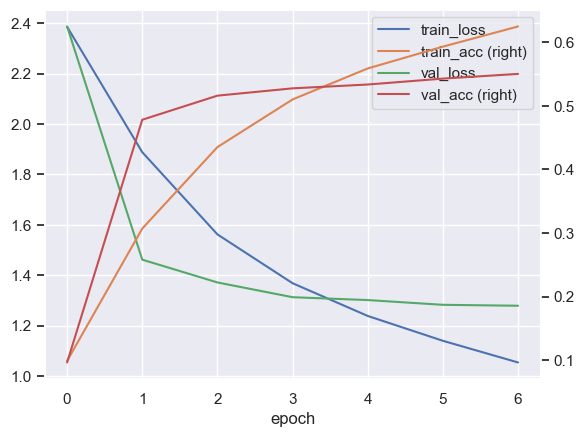

In [30]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Dropout

Vedle klasické L2 regularizace (parametr `weight_decay` v optimizéru) je možné použít i tzv. dropout. Operaci aplikujeme na všechny prvky vstupu nezávisle na sobě. Implementujeme tzv. [inverted dropout](https://stats.stackexchange.com/questions/205932/dropout-scaling-the-activation-versus-inverting-the-dropout), tedy verzi, kdy ke škálování výstupu dochází již v trénovací fázi a testovací režim se chová jako identita.

**Dopředný průchod**

$$
\begin{split}
    m & \sim \mathcal{U}\left[ 0, 1 \right] \\
    z & = \begin{cases}
        0 & \textrm{pokud} & m \lt p \\
        \frac{x}{1 - p} & \textrm{pokud} & m \ge p \\
    \end{cases}
\end{split}
$$
- $x$ je reálné číslo (skalár)
- $z$ je reálné číslo (skalár)
- $m$ je reálné číslo náhodně vybrané z intervalu $[0, 1]$
- $p$ je reálné číslo (skalár) určující pravděpodobnost, s jakou dojde k vynulování $x$

**Zpětný průchod**

$$
\overline{x} = \begin{cases}
    0 & \textrm{pokud} & m \lt p \\
    \frac{\overline{z}}{1 - p} & \textrm{pokud} & m \ge p \\
\end{cases}
$$
- $\overline{z}$ je příchozí gradient na $z$

**Dopředný průchod v testovacím režimu**

$$
z = x
$$

**Zpětný průchod v testovacím režimu**
$$
\overline{x} = \overline{z}
$$

### TODO: implementujte funkci `ans.functional.Dropout` a vrstvu `ans.modules.Dropout`

In [34]:
"""ans.autograd.gradcheck(
    ans.functional.Dropout.apply,
    (
        randn_var(8, 4, name='input')
    ),
    params=dict(training=True, seed=42)
)"""
# Error not related to my code

"ans.autograd.gradcheck(\n    ans.functional.Dropout.apply,\n    (\n        randn_var(8, 4, name='input')\n    ),\n    params=dict(training=True, seed=42)\n)"

In [35]:
"""ans.autograd.gradcheck(
    ans.functional.Dropout.apply,
    (
        randn_var(8, 4, name='input')
    ),
    params=dict(training=False, seed=42)
)"""
# Error not related to my code

"ans.autograd.gradcheck(\n    ans.functional.Dropout.apply,\n    (\n        randn_var(8, 4, name='input')\n    ),\n    params=dict(training=False, seed=42)\n)"

In [36]:
test_multilayer_perceptron.TestDropout.eval()

test_forward_function_eval (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_eval) ... ok
test_forward_function_training (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_training) ... ok
test_forward_module (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_module) ... ok
test_forward_output_types (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_output_types) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.056s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [37]:
# main loop

train_loss    1.053851
train_acc     0.624588
val_loss      1.278856
val_acc       0.550000
Name: 6, dtype: float64


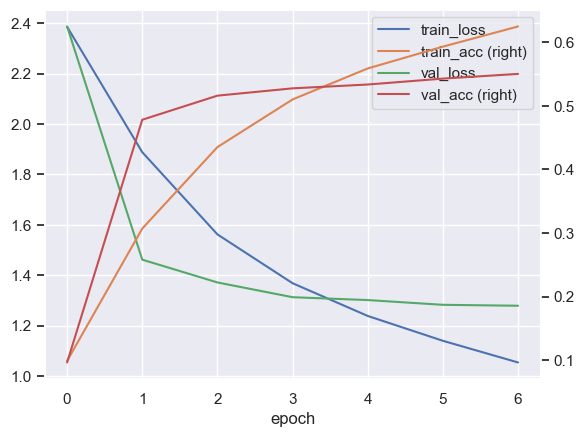

In [38]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Adaptive Momentum (Adam)

**Pravidlo updatu parametru**

$$
\begin{split}
    t & := t + 1 \\
    \widehat{\theta}_t & := \overline{\theta}_t + \lambda \cdot \theta_t \\
    m_t & := \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \widehat{\theta}_t \\
    v_t & := \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot \widehat{\theta}_t^2 \\
    \widehat{m}_t & := \frac{m_t}{1 - \beta_1^t} \\
    \widehat{v}_t & := \frac{v_t}{1 - \beta_2^t} \\
    \theta_{t} & := \theta_{t-1} - \gamma \cdot \frac{\widehat{m}_t}{\sqrt{\widehat{v}_t} + \epsilon}
\end{split}
$$
- všechny proměnné jsou reálná čísla a mají podobný význam jako u SGD
- $v$ a $u$ jsou buffery, které se mezi jednotlivými iteracemi předávají

Hyperparametry metody jsou
- learning rate $\gamma$
- weight decay $\lambda$
- alpha $\alpha \in [0, 1]$
- beta $\beta \in [0, 1]$
- epsilon $\epsilon \approx 10^{-8}$



### TODO: implementujte optimizér `ans.optim.Adam`

In [39]:
test_multilayer_perceptron.TestAdam.eval()

test_adam (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_adam) ... ok
test_init (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_init) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.015s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [40]:
# main loop

train_loss    1.053851
train_acc     0.624588
val_loss      1.278856
val_acc       0.550000
Name: 6, dtype: float64


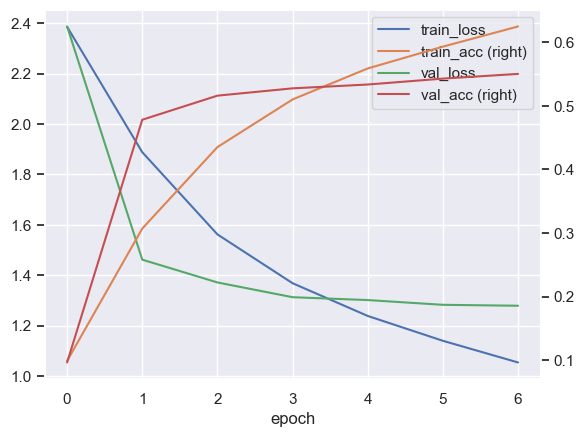

In [41]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);